In [5]:
import os                      # Untuk cek file/folder, list isi folder, dan join path (operasi file dasar)
import zipfile                 # Untuk membuka dan mengekstrak file .zip
import gdown                   # Untuk download Google Drive pakai file_id (lebih stabil dari link share biasa)
import shutil                  # Untuk hapus folder (rmtree) dan rename/mindah folder (operasi file sistem)

# =====================================================================
# SETUP DATASET (SMART EXTRACTION)
# =====================================================================
# Tujuan: dataset berakhir rapi seperti:
# ./jagung_dataset/Blight/..., ./jagung_dataset/Healthy/..., dst.

file_id = '1UFHIQeopus6M2M0RitFXXbFP3rCtOe0M'   # ID unik file di Drive (stabil; tidak berubah walau nama file berubah)
output_zip = 'jagung_dataset.zip'               # Nama file zip lokal di Colab (dipilih simpel & mudah dicari)
target_folder_name = 'jagung_dataset'           # Nama folder final (konsisten untuk dipakai base_dir training)

url = f'https://drive.google.com/uc?id={file_id}'  # Format direct-download paling cocok untuk gdown

# =====================================================================
# LANGKAH 1: DOWNLOAD ZIP (HANYA JIKA BELUM ADA)
# =====================================================================
# Kenapa pakai "if not exists"?
# -> Kalau cell di-run ulang, tidak download lagi (hemat waktu dan kuota).
if not os.path.exists(output_zip):                # Jika file zip belum ada di workspace Colab
    print("📥 Sedang mendownload dataset...")     # Info proses
    gdown.download(url, output_zip, quiet=False)  # quiet=False = tampilkan progress (biar yakin download jalan)
    print("✅ Download Selesai!")
else:
    print("ℹ️ File zip sudah ada.")               # Skip download bila file sudah ada (lebih efisien)

# =====================================================================
# LANGKAH 2: EKSTRAK PINTAR (ANTI FOLDER DOBEL)
# =====================================================================
# Masalah umum:
# - Ada zip yang isinya: DatasetJagung/Blight/... (punya folder induk)
# - Ada zip yang isinya langsung: Blight/... (tanpa folder induk)
# Kalau tidak ditangani, bisa jadi folder dobel: jagung_dataset/jagung_dataset/Blight/...

# Kenapa hapus folder lama?
# -> Biar hasil ekstrak bersih dan tidak tercampur data lama/duplikat.
# -> Menghindari kasus file lama tertinggal lalu bikin label/class salah.
if os.path.exists(target_folder_name):            # Jika folder target sudah pernah dibuat sebelumnya
    shutil.rmtree(target_folder_name)             # Hapus total (aman karena ini folder dataset yang akan dibuat ulang)

print("📦 Mengekstrak...")                        # Info proses ekstraksi

with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Buka file zip (read-only)
    # zip_ref.namelist() -> daftar seluruh path file di zip, contoh:
    # "DatasetJagung/Blight/img1.jpg" atau "Blight/img1.jpg"
    #
    # name.split('/')[0] -> ambil item top-level (folder paling luar)
    # Kita kumpulkan jadi set agar unik (tidak duplikat).
    top_level_items = {name.split('/')[0] for name in zip_ref.namelist()}  # Set = unik (1x saja per nama folder)
    top_level_items.discard('')                # Buang string kosong kalau ada (kadang zip punya root kosong)

    # -------------------------------------------------------------
    # LOGIKA ANTI DOBEL FOLDER
    # -------------------------------------------------------------
    if len(top_level_items) == 1:
        # KASUS A: hanya ada 1 item top-level -> biasanya folder induk tunggal.
        # Contoh: {'DatasetJagung'}
        folder_asli = list(top_level_items)[0]      # Ambil nama folder induk yang ada di dalam zip
        print(f"   👉 Terdeteksi folder induk di dalam zip: '{folder_asli}'")

        # Kenapa extract ke '.' (root workspace)?
        # -> Karena zip sudah punya folder induk; kalau ekstrak ke target_folder_name,
        #    hasilnya bisa dobel: jagung_dataset/DatasetJagung/...
        zip_ref.extractall('.')                      # Ekstrak sesuai struktur zip apa adanya

        # Kalau nama folder induk di zip bukan "jagung_dataset", kita rename supaya konsisten.
        # Konsisten penting untuk pipeline training: base_dir selalu sama.
        if folder_asli != target_folder_name:
            print(f"   ✏️ Mengubah nama folder '{folder_asli}' menjadi '{target_folder_name}'")

            # Pengaman: jika (karena alasan tertentu) target_folder_name sudah muncul, hapus dulu biar rename tidak gagal.
            if os.path.exists(target_folder_name):
                shutil.rmtree(target_folder_name)

            os.rename(folder_asli, target_folder_name)  # Rename folder induk -> nama yang kita inginkan

    else:
        # KASUS B: lebih dari 1 item top-level -> biasanya zip berisi folder kelas langsung.
        # Contoh: {'Blight', 'Common_Rust', 'Healthy', ...}
        print("   👉 Tidak ada folder induk, membuat folder penampung baru...")

        # Kenapa extract ke target_folder_name?
        # -> Supaya folder kelas tidak “berserakan” di root workspace.
        # -> Hasil rapi: jagung_dataset/Blight, jagung_dataset/Healthy, dst.
        zip_ref.extractall(target_folder_name)

# =====================================================================
# SET BASE DIRECTORY UNTUK TRAINING
# =====================================================================
# Kenapa base_dir = target_folder_name?
# -> Keras flow_from_directory butuh 1 folder yang LANGSUNG berisi folder kelas.
base_dir = target_folder_name

print(f"✅ Dataset siap! Folder Base Directory: {base_dir}")
print(f"📂 Isi Folder: {os.listdir(base_dir)}")   # Harusnya: ['Blight','Common_Rust','Gray_Leaf_Spot','Healthy']

# Catatan interpretasi:
# - Jika outputnya malah ['jagung_dataset'] (folder di dalam folder), berarti zip punya struktur yang berbeda dari asumsi.
#   Solusi cepat: lihat isi foldernya dengan os.listdir(base_dir) lalu turun 1 level kalau perlu.


📥 Sedang mendownload dataset...


Downloading...
From (original): https://drive.google.com/uc?id=1UFHIQeopus6M2M0RitFXXbFP3rCtOe0M
From (redirected): https://drive.google.com/uc?id=1UFHIQeopus6M2M0RitFXXbFP3rCtOe0M&confirm=t&uuid=c290b6f0-ff47-4da5-82bb-20029eceaf24
To: /content/jagung_dataset.zip
100%|██████████| 163M/163M [00:00<00:00, 290MB/s]


✅ Download Selesai!
📦 Mengekstrak...
   👉 Terdeteksi folder induk di dalam zip: 'jagung_dataset'
✅ Dataset siap! Folder Base Directory: jagung_dataset
📂 Isi Folder: ['Common_Rust', 'Blight', 'Healthy', 'Gray_Leaf_Spot']


In [8]:
# =========================
# TRAINING FINAL (ADIL + REPRODUCIBLE) - TANPA CALLBACKS - .keras
# MobileNetV3, EfficientNet, DenseNet
# =========================

import os                                            # Akses path/file; berguna kalau mau cek dataset/model ada/tidak
import time                                          # Untuk hitung durasi training (biar bisa dibandingkan antar model)
import numpy as np                                   # Operasi numerik (ceil, unique, array)
import tensorflow as tf                              # Framework deep learning utama

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Generator gambar + augmentasi + split train/val
from tensorflow.keras.models import Model            # Bangun model via Functional API (fleksibel untuk TL)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout  # Head klasifikasi + pooling + regularisasi
from tensorflow.keras.optimizers import Adam         # Adam: default kuat & stabil untuk transfer learning

from sklearn.utils import class_weight               # Untuk hitung bobot kelas (imbalance) agar training lebih fair

# ============================================================
# 0) REPRODUCIBILITY (BIAR HASIL LEBIH STABIL DI PAPER)
# ============================================================
SEED = 42                                            # Angka seed standar (sering dipakai) agar random bisa diulang
tf.keras.utils.set_random_seed(SEED)                 # Set seed TF + NumPy + python random -> hasil lebih konsisten antar run
tf.config.experimental.enable_op_determinism()        # Memaksa operasi deterministik jika didukung hardware/TF (lebih stabil)

# Catatan: determinism bisa membuat training sedikit lebih lambat, tapi bagus untuk penelitian (reproducibility).

# ============================================================
# 1) BASE MODELS (PRETRAINED IMAGENET)
# ============================================================
from tensorflow.keras.applications import MobileNetV3Large          # Model ringan, cocok untuk deployment (mobile/edge)
from tensorflow.keras.applications.efficientnet import EfficientNetB0  # Efisien dengan akurasi kuat, sering jadi baseline bagus
from tensorflow.keras.applications.densenet import DenseNet121      # Kaya fitur (feature reuse), kadang lebih detail tapi lebih berat

# ============================================================
# 2) PREPROCESS INPUT SESUAI MODEL
# ============================================================
# Kenapa beda-beda?
# Karena masing-masing arsitektur punya "aturan" normalisasi input yang berbeda (skala/mean/std).
# Jika preprocess salah, performa bisa drop signifikan meskipun model bagus.
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenetv3_prep
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_prep
from tensorflow.keras.applications.densenet import preprocess_input as densenet_prep

# ============================================================
# 3) KONFIG UTAMA
# ============================================================
base_dir = "jagung_dataset"                          # Folder dataset hasil ekstraksi; harus berisi subfolder per kelas

IMG_SIZE = (224, 224)                                # 224x224: ukuran standar ImageNet -> kompatibel untuk model pretrained
# Kenapa 224?
# - Mayoritas backbone pretrained default di 224 (lebih mudah, minim mismatch)
# - Cukup detail untuk tekstur/lesi daun, tapi tidak terlalu berat komputasi

BATCH_SIZE = 32                                      # Batch 32: sweet spot umum (stabil gradien & biasanya muat di GPU Colab)
# Kenapa 32?
# - Lebih stabil dari batch kecil (8/16) untuk training TL
# - Tidak terlalu besar sehingga masih aman untuk VRAM Colab
# Jika OOM: turunkan 16 atau 8 (trade-off: training lebih lambat & BN makin sensitif)

VAL_SPLIT = 0.2                                      # 20% validasi: standar 80/20 untuk dataset ukuran menengah
# Kenapa 0.2?
# - Memberi data validasi cukup banyak agar metrik stabil
# - Tapi tidak mengurangi data training terlalu banyak

EPOCHS_HEAD = 10                                     # Head training 10 epoch: cukup untuk adaptasi classifier baru
# Kenapa 10?
# - Head (Dense softmax) baru mulai dari random -> butuh beberapa epoch untuk "nyambung"
# - Tidak terlalu banyak agar belum overfit sebelum fine-tuning

EPOCHS_FINE = 5                                      # Fine-tuning 5 epoch: penyesuaian halus fitur backbone
# Kenapa 5?
# - Fine-tune biasanya cepat memberikan improvement
# - Terlalu lama rawan overfit pada dataset kecil/menengah

def build_and_train(model_name, save_name):
    print(f"\n{'='*55}")                              # Pembatas log agar output rapi dan mudah dibaca
    print(f"🚀 TRAINING: {model_name.upper()}")       # Nama model sedang diproses
    print(f"{'='*55}")

    start_time = time.time()                          # Mulai hitung waktu total (bandingkan efisiensi antar model)

    # ============================================================
    # A) PILIH BASE MODEL + PREPROCESS
    # ============================================================
    # Kenapa weights="imagenet"?
    # - Transfer learning: backbone sudah belajar fitur umum (edge/tekstur) -> cepat konvergen dan lebih general
    # Kenapa include_top=False?
    # - Top ImageNet = classifier 1000 kelas -> tidak relevan untuk 4 kelas jagung
    # - Kita ganti top dengan Dense(num_classes) sendiri
    if model_name == "mobilenetv3":
        preprocessing_func = mobilenetv3_prep         # Wajib sesuai model
        base = MobileNetV3Large(
            weights="imagenet",                       # Pretrained -> percepat training & biasanya akurasi naik
            include_top=False,                        # Buang classifier 1000 kelas
            input_shape=(224, 224, 3)                 # Konsisten dengan IMG_SIZE dan format RGB
        )
    elif model_name == "efficientnet":
        preprocessing_func = efficientnet_prep
        base = EfficientNetB0(
            weights="imagenet",
            include_top=False,
            input_shape=(224, 224, 3)
        )
    elif model_name == "densenet":
        preprocessing_func = densenet_prep
        base = DenseNet121(
            weights="imagenet",
            include_top=False,
            input_shape=(224, 224, 3)
        )
    else:
        raise ValueError("model_name harus: mobilenetv3 / efficientnet / densenet")  # Guard agar tidak typo

    # ============================================================
    # B) DATA PIPELINE (TRAIN AUGMENT, VAL TANPA AUGMENT ACAK)
    # ============================================================
    # Kenapa augmentasi ini?
    # - Meniru kondisi lapangan: daun bisa miring, bergeser, beda cahaya, beda jarak kamera
    # - Mengurangi overfitting (model tidak menghafal background)
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_func,    # PENTING: preprocessing sesuai backbone

        rotation_range=20,                            # Rotasi ±20°: realistis untuk foto daun (tidak ekstrem)
        horizontal_flip=True,                         # Flip kiri-kanan: aman karena penyakit tidak tergantung orientasi

        width_shift_range=0.1,                        # Geser 10%: variasi framing tanpa “kehilangan” objek utama
        height_shift_range=0.1,                       # Geser 10% vertikal

        brightness_range=[0.8, 1.2],                  # Variasi cahaya ±20%: cocok simulasi bayangan/terik
        zoom_range=0.2,                               # Zoom 20%: variasi jarak kamera

        fill_mode="nearest",                          # Isi area kosong dengan piksel terdekat: cepat & stabil untuk daun
        validation_split=VAL_SPLIT                    # Split internal train/val (80/20) secara konsisten
    )

    # Kenapa val_datagen tanpa augment acak?
    # - Validasi harus merefleksikan data “asli” (tanpa gangguan augmentasi)
    # - Agar metrik validasi stabil dan dapat dibandingkan
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_func,    # Tetap preprocess sesuai model
        validation_split=VAL_SPLIT
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,                                     # Folder utama dataset
        target_size=IMG_SIZE,                         # Resize ke 224x224: sesuai input backbone
        batch_size=BATCH_SIZE,                        # 32: stabil & cepat
        class_mode="categorical",                     # Multi-class -> one-hot encoding
        subset="training",                            # Ambil porsi 80% training
        shuffle=True,                                 # Training wajib shuffle agar gradien tidak bias urutan file
        seed=SEED                                     # Seed agar shuffle konsisten antar run (paper)
    )

    val_generator = val_datagen.flow_from_directory(
        base_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        subset="validation",                          # Ambil porsi 20% validasi
        shuffle=False,                                # Evaluasi butuh urutan konsisten (CM/F1 akurat)
        seed=SEED
    )

    num_classes = len(train_generator.class_indices)  # Otomatis: aman kalau suatu saat kelas bertambah/berkurang

    # ============================================================
    # C) STEPS PER EPOCH (BIAR EPOCH KONSISTEN)
    # ============================================================
    # Kenapa ceil(samples / batch)?
    # - Kalau data tidak habis dibagi batch, batch terakhir lebih kecil (sisa)
    # - ceil memastikan semua sampel tetap diproses 1 epoch (tidak ada yang “ketinggalan”)
    # - Membuat definisi epoch konsisten (penting untuk fairness antar model)
    steps_per_epoch = int(np.ceil(train_generator.samples / BATCH_SIZE))
    val_steps = int(np.ceil(val_generator.samples / BATCH_SIZE))

    # ============================================================
    # D) CLASS WEIGHT (JIKA IMBALANCE)
    # ============================================================
    # Kenapa class_weight='balanced'?
    # - Kalau kelas Healthy lebih banyak, model bisa cenderung “menang” dengan menebak Healthy
    # - Class weight menambah penalti pada kelas minoritas -> training lebih adil
    train_classes = train_generator.classes           # Label index untuk semua sampel train
    cw = class_weight.compute_class_weight(
        class_weight="balanced",                      # Rumus standar: bobot ~ 1/frekuensi
        classes=np.unique(train_classes),             # Daftar kelas unik
        y=train_classes
    )
    class_weights_dict = dict(enumerate(cw))          # Format yang diterima Keras: {index_kelas: bobot}
    print(f"⚖️ Class Weights: {class_weights_dict}")  # Debug: lihat kelas mana minoritas (bobot lebih besar)

    # ============================================================
    # E) SUSUN MODEL (HEAD)
    # ============================================================
    base.trainable = False                            # Freeze backbone: latih head dulu agar tidak merusak fitur pretrained

    x = base.output
    x = GlobalAveragePooling2D()(x)                   # GAP: lebih sedikit parameter, lebih tahan overfit daripada Flatten

    # Kenapa dropout beda?
    # - MobileNetV3 lebih kecil/ringan -> dropout besar kadang membuat belajar terlalu sulit
    # - EfficientNet/DenseNet lebih kuat -> dropout sedikit lebih besar membantu generalisasi
    x = Dropout(0.2 if model_name == "mobilenetv3" else 0.3)(x)

    outputs = Dense(num_classes, activation="softmax")(x)  # Softmax: probabilitas total = 1 untuk multiclass
    model = Model(inputs=base.input, outputs=outputs)

    # Kenapa LR 1e-3 untuk phase head?
    # - Head layer baru random -> butuh belajar cepat
    # - Adam + 1e-3 umumnya stabil untuk layer baru
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",              # Cocok untuk one-hot multiclass
        metrics=["accuracy"]                          # Metrik cepat dibaca (nanti detail pakai F1/CM)
    )

    # ============================================================
    # F) PHASE 1: TRAIN HEAD (FIXED 10 EPOCH)
    # ============================================================
    print(f"\n⏳ Phase 1 (Head) - {EPOCHS_HEAD} epochs")
    h1 = model.fit(
        train_generator,
        epochs=EPOCHS_HEAD,                           # 10 epoch: head adaptasi cukup
        steps_per_epoch=steps_per_epoch,              # Epoch konsisten & semua sampel ter-cover
        validation_data=val_generator,
        validation_steps=val_steps,                   # Validasi konsisten
        class_weight=class_weights_dict,              # Menyeimbangkan kelas
        verbose=1
    )

    # ============================================================
    # G) PHASE 2: FINE-TUNE (FIXED 5 EPOCH)
    # ============================================================
    print(f"\n🔓 Phase 2 (Fine-tune) - {EPOCHS_FINE} epochs")
    base.trainable = True                             # Buka backbone agar fitur bisa adaptasi ke domain daun jagung

    # Kenapa proporsi unfreeze beda?
    # - EfficientNet sering sensitif -> unfreeze lebih sedikit dulu (20% terakhir) agar stabil
    # - DenseNet & MobileNetV3 bisa di-unfreeze lebih banyak untuk adaptasi domain
    fine_tune_at = int(len(base.layers) * (0.6 if model_name in ["densenet", "mobilenetv3"] else 0.8))

    for layer in base.layers[:fine_tune_at]:
        layer.trainable = False                       # Bekukan layer awal (fitur umum: edge/tekstur)

    # Kenapa BatchNorm di-freeze?
    # - BN menyimpan running mean/var
    # - Dengan batch kecil, statistik BN bisa "rusak" saat fine-tune -> akurasi bisa drop
    for layer in base.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    # Kenapa LR 1e-5 saat fine-tune?
    # - Fine-tune harus pelan agar tidak merusak fitur pretrained (catastrophic forgetting)
    # - 1e-5 umum digunakan untuk fine-tuning CNN
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    h2 = model.fit(
        train_generator,
        epochs=EPOCHS_FINE,                           # 5 epoch: penyesuaian halus
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=val_steps,
        class_weight=class_weights_dict,
        verbose=1
    )

    # ============================================================
    # H) SAVE MODEL (LAST EPOCH)
    # ============================================================
    # Kenapa include_optimizer=False?
    # - Optimizer tidak dibutuhkan untuk inference/deployment
    # - File lebih kecil dan loading lebih ringan
    model.save(save_name, include_optimizer=False)
    print(f"💾 Saved: {save_name}")

    duration = time.time() - start_time
    print(f"✅ Done in {duration:.2f} seconds")       # Penting buat bandingkan efisiensi antar model

    # Gabungkan history (agar bisa plot 15 epoch total)
    full_history = {}
    for k in h1.history.keys():
        full_history[k] = h1.history[k] + h2.history[k]

    return full_history, duration


# ============================================================
# RUN 3 MODELS (ADIL: SETTING + EPOCH SAMA)
# ============================================================
# Kenapa run berurutan?
# - Setting sama (IMG_SIZE, BATCH_SIZE, augment, epoch) -> perbandingan adil
# - Output: 3 model .keras siap untuk Streamlit + ensemble
hist_mobv3, time_mobv3 = build_and_train("mobilenetv3", "model_jagung_mobilenetv3_vFinal.keras")
hist_eff,  time_eff    = build_and_train("efficientnet", "model_jagung_efficientnet_vFinal.keras")
hist_den,  time_den    = build_and_train("densenet",     "model_jagung_densenet_vFinal.keras")



🚀 TRAINING: MOBILENETV3
Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.
⚖️ Class Weights: {0: np.float64(0.9138495092693566), 1: np.float64(0.8019138755980861), 2: np.float64(1.8217391304347825), 3: np.float64(0.9010752688172043)}

⏳ Phase 1 (Head) - 10 epochs


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 529ms/step - accuracy: 0.6089 - loss: 0.9716 - val_accuracy: 0.9127 - val_loss: 0.2619
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 513ms/step - accuracy: 0.8636 - loss: 0.3769 - val_accuracy: 0.9258 - val_loss: 0.2199
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 53s 509ms/step - accuracy: 0.8957 - loss: 0.3050 - val_accuracy: 0.9330 - val_loss: 0.1951
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 53s 510ms/step - accuracy: 0.9154 - loss: 0.2584 - val_accuracy: 0.9354 - val_loss: 0.1821
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 53s 506ms/step - accuracy: 0.9156 - loss: 0.2462 - val_accuracy: 0.9282 - val_loss: 0.1871
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 53s 509ms/step - accuracy: 0.9167 - loss: 0.2268 - val_accuracy: 0.9294 - val_loss: 0.1875
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 514ms/step - accuracy: 0.9267 - loss: 0.2177 - val_accuracy: 0.9390 - val_loss: 0.1809
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 516ms/step - accuracy: 0.9380 - loss: 0

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 69s 565ms/step - accuracy: 0.6674 - loss: 0.8410 - val_accuracy: 0.9163 - val_loss: 0.2650
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 535ms/step - accuracy: 0.8903 - loss: 0.3688 - val_accuracy: 0.9222 - val_loss: 0.2236
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 535ms/step - accuracy: 0.9084 - loss: 0.2733 - val_accuracy: 0.9366 - val_loss: 0.2067
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 57s 543ms/step - accuracy: 0.9104 - loss: 0.2627 - val_accuracy: 0.9390 - val_loss: 0.1955
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 537ms/step - accuracy: 0.9190 - loss: 0.2467 - val_accuracy: 0.9378 - val_loss: 0.1855
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 535ms/step - accuracy: 0.9236 - loss: 0.2298 - val_accuracy: 0.9378 - val_loss: 0.1797
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 57s 541ms/step - accuracy: 0.9156 - loss: 0.2312 - val_accuracy: 0.9474 - val_loss: 0.1647
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 57s 541ms/step - accuracy: 0.9343 - loss: 0

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 79s 642ms/step - accuracy: 0.4896 - loss: 1.3004 - val_accuracy: 0.9103 - val_loss: 0.3061
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 599ms/step - accuracy: 0.8316 - loss: 0.4576 - val_accuracy: 0.9187 - val_loss: 0.2531
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 601ms/step - accuracy: 0.8520 - loss: 0.4104 - val_accuracy: 0.9234 - val_loss: 0.2331
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 596ms/step - accuracy: 0.8834 - loss: 0.3260 - val_accuracy: 0.9306 - val_loss: 0.2069
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 597ms/step - accuracy: 0.8925 - loss: 0.2955 - val_accuracy: 0.9330 - val_loss: 0.1947
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 62s 596ms/step - accuracy: 0.8955 - loss: 0.3096 - val_accuracy: 0.9390 - val_loss: 0.1721
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 598ms/step - accuracy: 0.8987 - loss: 0.2821 - val_accuracy: 0.9366 - val_loss: 0.1867
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 602ms/step - accuracy: 0.9029 - loss: 0

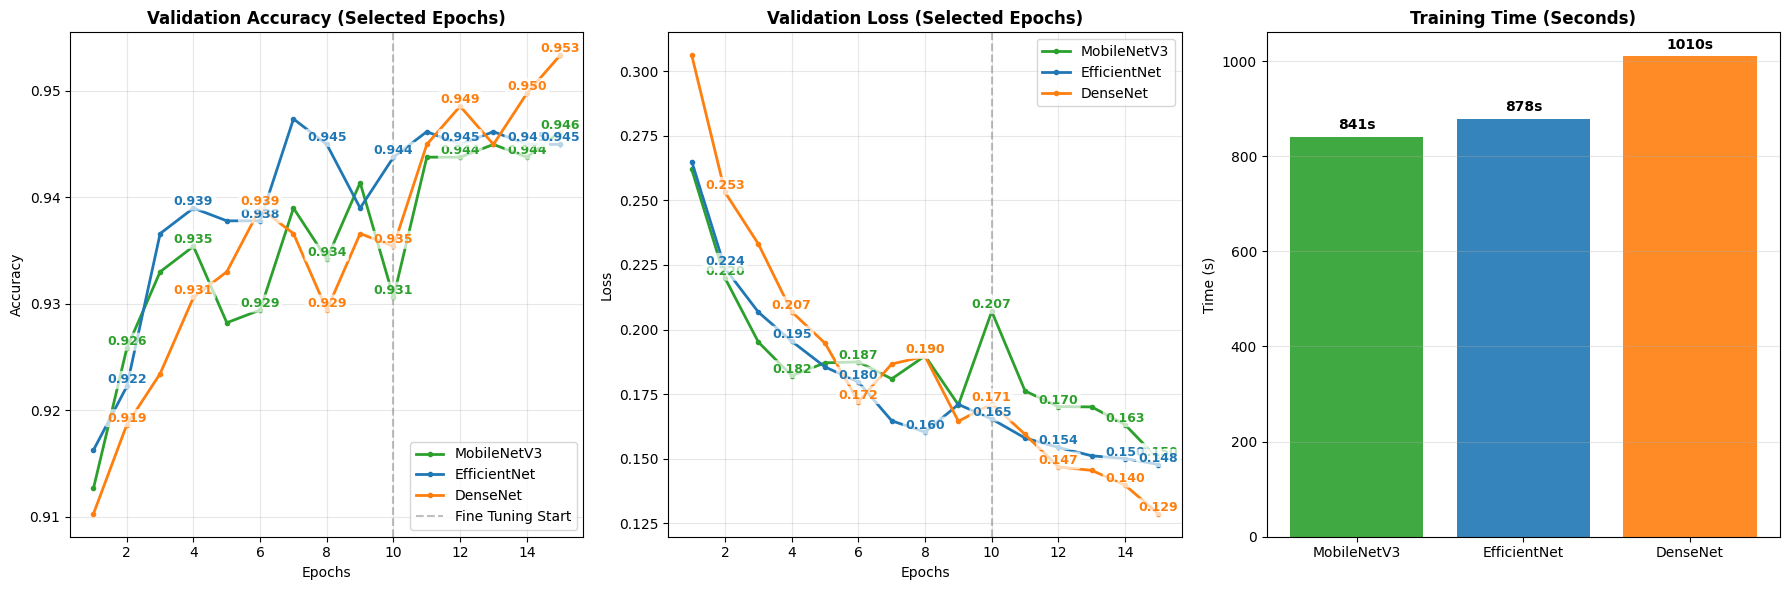

In [28]:
import matplotlib.pyplot as plt                    # Matplotlib: library standar untuk membuat grafik (stabil + umum di paper)
import numpy as np                                 # NumPy: operasi numerik (max, array), ringan dan cepat

def plot_results_annotated(
    histories, times, names,                       # histories: list history (dict / keras History), times: durasi, names: label model
    fine_tune_start=10,                            # Garis batas fine-tuning mulai di epoch ke-10 (sesuai setting training: head=10 epoch)
    annotate_every=2,                              # Tulis angka tiap 2 epoch -> grafik tidak penuh/berantakan, tetap informatif
    decimals=3,                                    # 3 desimal -> bisa bedakan performa tipis (0.941 vs 0.944) pada paper/analisis
    figsize=(18, 6),                               # Lebar 18 karena 3 subplot sejajar; tinggi 6 cukup untuk judul+legend+angka
    save_path=None,                                # Jika diisi -> file disimpan (png/pdf/svg). None -> hanya tampil di layar
    dpi=300                                        # 300 DPI -> standar kualitas gambar untuk laporan/paper (tajam saat dicetak)
):
    # Palet warna konsisten (hijau/biru/oranye/ungu/merah)
    colors = ['#2ca02c', '#1f77b4', '#ff7f0e', '#9467bd', '#d62728']  # Warna kontras & umum dipakai (mudah dibedakan)
    current_colors = colors[:len(names)]            # Ambil sebanyak jumlah model -> aman walau modelnya 2/3/4

    # Ambil metric dengan aman (support dict atau History keras)
    def get_metric(hist, key):                      # Fungsi helper agar kode fleksibel: hist bisa dict atau objek History Keras
        if isinstance(hist, dict):                  # Jika hist adalah dict (mis. full_history yang kamu gabungkan manual)
            return hist.get(key, None)              # .get aman: kalau key tidak ada -> None (tidak crash)
        if hasattr(hist, "history"):                # Jika hist adalah keras.callbacks.History
            return hist.history.get(key, None)      # Ambil dari hist.history
        return None                                 # Kalau format tidak dikenal, return None -> di-skip dengan warning

    safe_times = [t if t is not None else 0 for t in times]  # Kalau ada waktu None, diganti 0 supaya bar chart tidak error
    max_time = max(safe_times) if len(safe_times) > 0 else 1 # Untuk offset teks di atas bar; fallback 1 agar tidak zero divide

    plt.figure(figsize=figsize)                     # Setup kanvas utama; figsize besar agar 3 panel + angka tidak bertumpuk

    # =========================
    # 1) VALIDATION ACCURACY
    # =========================
    plt.subplot(1, 3, 1)                            # 1 baris, 3 kolom, panel ke-1 (kiri)

    for hist, name, color in zip(histories, names, current_colors):  # zip -> urutan history-nama-warna sinkron
        val_acc = get_metric(hist, 'val_accuracy')  # Ambil val_accuracy (lebih penting untuk generalisasi daripada train acc)
        if val_acc is None:                         # Kalau history tidak punya metrik ini, jangan crash
            print(f"⚠️ {name} tidak punya 'val_accuracy' -> skip plot acc")
            continue

        epochs = range(1, len(val_acc) + 1)         # Epoch mulai dari 1 (lebih natural untuk pembaca/paper)

        plt.plot(
            epochs, val_acc,                        # X=epoch, Y=val_accuracy
            label=name,                             # Legend label = nama model
            linewidth=2,                            # 2 -> cukup tebal terlihat, tapi tidak menutupi angka/marker
            color=color,                            # Warna konsisten per model
            marker='o',                             # Marker titik agar terlihat nilai per epoch
            markersize=3                            # 3 -> kecil supaya tidak ramai (karena ada anotasi)
        )

        # Tulis angka tiap N epoch saja (biar tidak penuh)
        for i, v in enumerate(val_acc, start=1):    # start=1 -> i langsung sesuai nomor epoch
            if (i % annotate_every) != 0 and i != len(val_acc):
                continue                            # Tampilkan hanya setiap annotate_every epoch + selalu tampilkan epoch terakhir

            plt.text(
                i, v,                               # Posisi teks tepat di titik (x=epoch, y=nilai)
                f'{v:.{decimals}f}',                # Format desimal dinamis: decimals=3 -> 0.953
                color=color,                        # Teks mengikuti warna garis -> mudah identifikasi model
                fontsize=9,                         # 9 -> cukup terbaca tanpa membuat plot penuh
                fontweight='bold',                  # Bold -> tetap terbaca saat disimpan/di-zoom
                ha='center', va='bottom',           # Center horizontal; bottom -> teks sedikit di atas titik
                bbox=dict(                          # Box putih transparan agar angka tetap jelas di atas garis/marker
                    boxstyle="round,pad=0.2",       # Pad kecil -> box rapi tidak kebesaran
                    fc="white",                     # White background -> kontras aman untuk semua warna garis
                    ec="none",                      # Tanpa border -> lebih clean
                    alpha=0.7                       # 0.7 -> transparan sedikit agar tidak menutupi plot sepenuhnya
                )
            )

    plt.axvline(
        x=fine_tune_start,                          # Garis vertikal batas fase (default 10 -> sesuai head training 10 epoch)
        color='gray', linestyle='--', alpha=0.5,    # Gray + dashed + alpha 0.5 -> penanda halus (tidak dominan)
        label='Fine Tuning Start'                   # Supaya pembaca tahu arti garisnya
    )

    plt.title('Validation Accuracy (Selected Epochs)', fontsize=12, fontweight='bold')  # Judul panel (jelas untuk paper)
    plt.xlabel('Epochs')                            # Label sumbu X
    plt.ylabel('Accuracy')                          # Label sumbu Y
    plt.legend(loc='lower right')                   # Biasanya area kosong saat acc tinggi; tidak menutupi garis
    plt.grid(True, alpha=0.3)                       # Grid tipis -> membantu baca nilai tanpa bikin ramai

    # =========================
    # 2) VALIDATION LOSS
    # =========================
    plt.subplot(1, 3, 2)                            # Panel ke-2 (tengah)

    for hist, name, color in zip(histories, names, current_colors):
        val_loss = get_metric(hist, 'val_loss')     # Loss validasi: indikator error (lebih sensitif dari accuracy)
        if val_loss is None:
            print(f"⚠️ {name} tidak punya 'val_loss' -> skip plot loss")
            continue

        epochs = range(1, len(val_loss) + 1)

        plt.plot(
            epochs, val_loss,
            label=name,
            linewidth=2,                            # Konsisten dengan panel accuracy
            color=color,
            marker='o',
            markersize=3
        )

        for i, v in enumerate(val_loss, start=1):
            if (i % annotate_every) != 0 and i != len(val_loss):
                continue                            # Sama: tampilkan tiap N epoch + epoch terakhir

            plt.text(
                i, v,
                f'{v:.{decimals}f}',                # 3 desimal juga penting, loss sering beda tipis
                color=color,
                fontsize=9,
                fontweight='bold',
                ha='center', va='bottom',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
            )

    plt.axvline(
        x=fine_tune_start,                          # Garis fase sama agar mudah banding before/after fine-tuning
        color='gray', linestyle='--', alpha=0.5
    )
    plt.title('Validation Loss (Selected Epochs)', fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')                   # Biasanya loss turun -> area atas bisa lebih kosong
    plt.grid(True, alpha=0.3)

    # =========================
    # 3) TRAINING TIME
    # =========================
    plt.subplot(1, 3, 3)                            # Panel ke-3 (kanan)

    bars = plt.bar(
        names, safe_times,                          # X=nama model, Y=durasi (detik)
        color=current_colors,                       # Warna sama dengan line plot -> konsistensi interpretasi
        alpha=0.9                                   # 0.9 -> sedikit lembut tapi tetap jelas
    )

    plt.title('Training Time (Seconds)', fontsize=12, fontweight='bold')
    plt.ylabel('Time (s)')
    plt.grid(axis='y', alpha=0.3)                   # Grid hanya Y -> fokus ke perbandingan tinggi bar

    for bar in bars:
        h = bar.get_height()                        # Tinggi batang = durasi training
        plt.text(
            bar.get_x() + bar.get_width()/2.,       # Teks tepat di tengah batang
            h + (0.01 * max_time),                  # Offset 1% dari max_time -> adaptif, teks tidak nempel batang
            f'{h:.0f}s',                            # 0 desimal -> waktu detik cukup dibulatkan
            ha='center', va='bottom',
            fontweight='bold', fontsize=10
        )

    plt.tight_layout()                              # Mencegah judul/label/legend saling tumpang tindih

    # Simpan file (opsional)
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')  # dpi=300 -> tajam; bbox tight -> tidak kepotong

    plt.show()                                      # Tampilkan grafik


# PEMAKAIAN:
plot_results_annotated(
    [hist_mobv3, hist_eff, hist_den],               # List history (pastikan punya key val_accuracy & val_loss)
    [time_mobv3, time_eff, time_den],               # List waktu training (detik)
    ['MobileNetV3', 'EfficientNet', 'DenseNet'],    # List nama model (urutan harus sama)
    fine_tune_start=10,                             # Karena head training 10 epoch -> fine-tune mulai setelah itu
    annotate_every=2,                               # Lebih rapi: angka tidak memenuhi plot (bisa jadi 1 kalau mau semua)
    decimals=3,                                     # Presisi cukup untuk analisis paper
    save_path="training_summary.png"                # Simpan sebagai PNG (bisa ganti .pdf / .svg)
)


📂 Dataset path evaluasi: /content/jagung_dataset
Found 836 images belonging to 4 classes.

🔍 Mengevaluasi MobileNetV3...
   -> Prediksi 836 gambar (steps=27) ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step

📊 Laporan Klasifikasi MobileNetV3:
                precision    recall  f1-score   support

        Blight     0.9429    0.8646    0.9021       229
   Common_Rust     0.9811    0.9923    0.9867       261
Gray_Leaf_Spot     0.7863    0.9035    0.8408       114
       Healthy     1.0000    0.9957    0.9978       232

      accuracy                         0.9462       836
     macro avg     0.9275    0.9390    0.9318       836
  weighted avg     0.9493    0.9462    0.9467       836

💾 Report disimpan: eval_outputs/MobileNetV3_classification_report.txt
🖼️ Confusion Matrix disimpan: eval_outputs/MobileNetV3_confusion_matrix.png


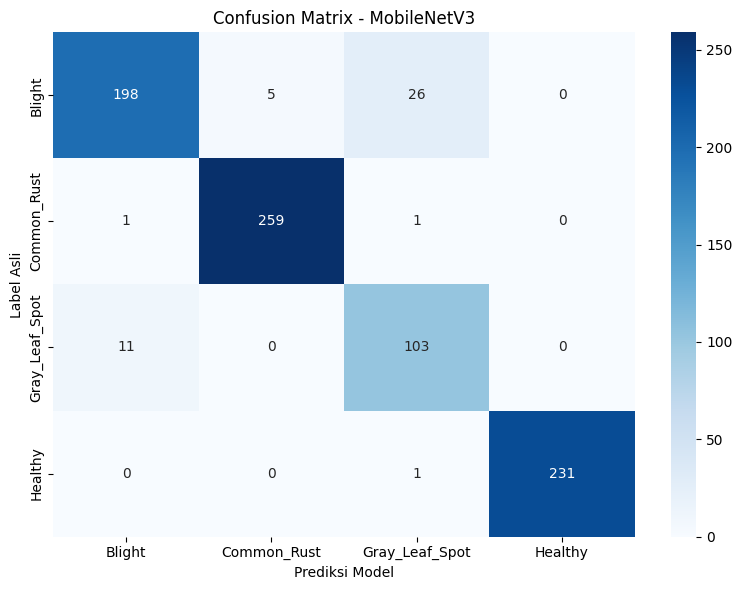

Found 836 images belonging to 4 classes.

🔍 Mengevaluasi EfficientNet...
   -> Prediksi 836 gambar (steps=27) ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step

📊 Laporan Klasifikasi EfficientNet:
                precision    recall  f1-score   support

        Blight     0.9148    0.8908    0.9027       229
   Common_Rust     0.9738    0.9962    0.9848       261
Gray_Leaf_Spot     0.8333    0.8333    0.8333       114
       Healthy     0.9957    0.9957    0.9957       232

      accuracy                         0.9450       836
     macro avg     0.9294    0.9290    0.9291       836
  weighted avg     0.9446    0.9450    0.9447       836

💾 Report disimpan: eval_outputs/EfficientNet_classification_report.txt
🖼️ Confusion Matrix disimpan: eval_outputs/EfficientNet_confusion_matrix.png


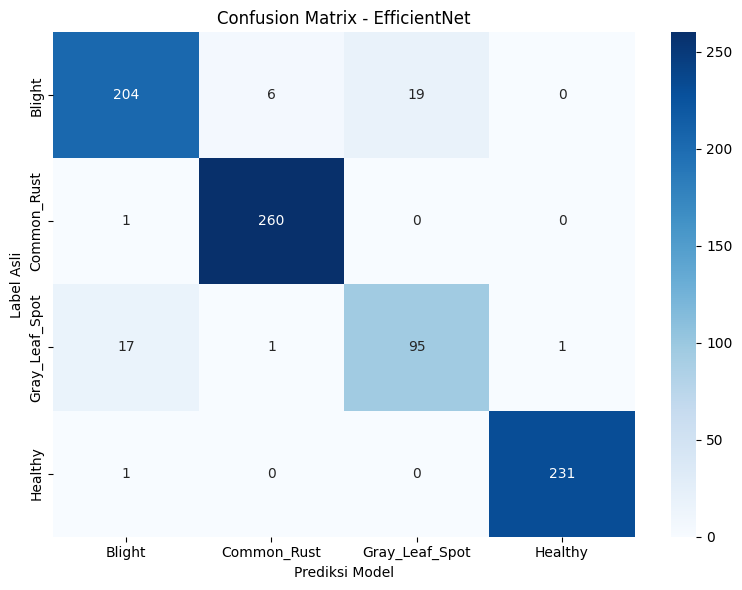

Found 836 images belonging to 4 classes.

🔍 Mengevaluasi DenseNet...
   -> Prediksi 836 gambar (steps=27) ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 378ms/step

📊 Laporan Klasifikasi DenseNet:
                precision    recall  f1-score   support

        Blight     0.9138    0.9258    0.9197       229
   Common_Rust     0.9923    0.9923    0.9923       261
Gray_Leaf_Spot     0.8482    0.8333    0.8407       114
       Healthy     1.0000    0.9957    0.9978       232

      accuracy                         0.9533       836
     macro avg     0.9386    0.9368    0.9377       836
  weighted avg     0.9533    0.9533    0.9533       836

💾 Report disimpan: eval_outputs/DenseNet_classification_report.txt
🖼️ Confusion Matrix disimpan: eval_outputs/DenseNet_confusion_matrix.png


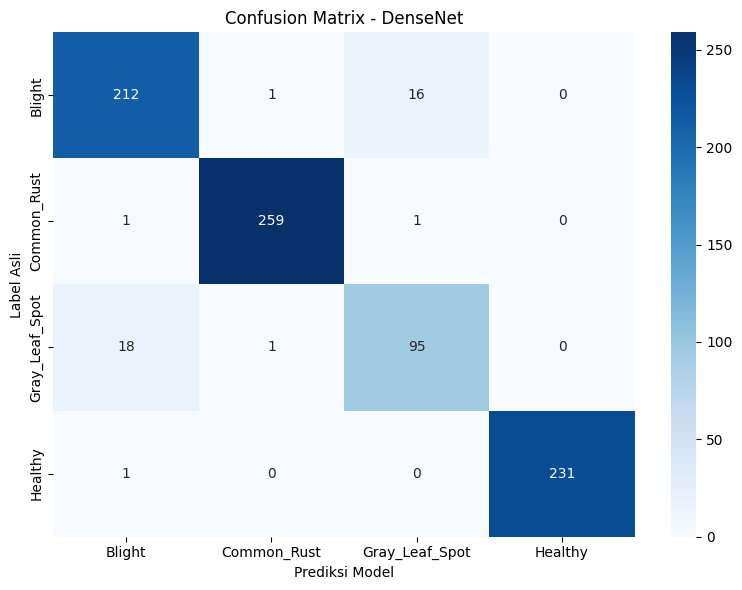

In [29]:
# =========================
# KODE EVALUASI MODEL (SAVE IMAGE + REPORT) - RAPI & AMAN
# =========================

from sklearn.metrics import classification_report, confusion_matrix     # metrik evaluasi: report (precision/recall/F1) + confusion matrix
import seaborn as sns                                                  # heatmap confusion matrix agar lebih visual & mudah dibaca
import numpy as np                                                     # operasi numerik: ceil, argmax, slicing
import os                                                              # urusan file/folder: path absolut, listdir, mkdir, join
import matplotlib.pyplot as plt                                        # plotting + savefig hasil confusion matrix
from tensorflow.keras.models import load_model                         # load model hasil training (.keras)
from tensorflow.keras.preprocessing.image import ImageDataGenerator    # pipeline baca gambar dari folder jadi generator

# Preprocess khusus per model (WAJIB sesuai training)
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenetv3_prep   # normalisasi input khusus MobileNetV3
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_prep  # normalisasi input khusus EfficientNet
from tensorflow.keras.applications.densenet import preprocess_input as densenet_prep          # normalisasi input khusus DenseNet


def evaluate_model(
    model_path,
    generator,
    model_name,
    save_dir="eval_outputs",          # folder output default; rapi, semua file eval terkumpul di satu tempat
    save_cm=True,                     # True: simpan confusion matrix PNG (berguna untuk paper/laporan)
    save_report=True,                 # True: simpan classification report TXT (mudah dikutip di paper)
    cm_figsize=(8, 6),                # 8x6 cukup besar untuk 4 kelas (angka & label masih terbaca jelas)
    dpi=300                           # 300 DPI standar kualitas “print/paper” (tajam untuk jurnal)
):
    """
    Evaluasi:
    - load model
    - predict seluruh data generator
    - classification_report
    - confusion matrix heatmap
    - SAVE gambar CM + SAVE report (opsional)
    """

    # ---------- siapkan folder output ----------
    os.makedirs(save_dir, exist_ok=True)  # exist_ok=True: kalau folder sudah ada tidak error (lebih aman untuk rerun)

    # nama file aman (tanpa spasi/simbol aneh)
    # alasan: nama file Windows/Linux aman, tidak bikin error saat save, dan konsisten untuk otomatisasi
    safe_name = "".join([c if c.isalnum() or c in ("-", "_") else "_" for c in model_name])

    print(f"\n🔍 Mengevaluasi {model_name}...")  # log agar jelas model apa yang sedang berjalan

    # compile=False: inferensi saja (lebih cepat & minim error "training config not found")
    # alasan: untuk evaluasi/predict, kita tidak butuh optimizer/loss, jadi compile tidak perlu
    model = load_model(model_path, compile=False)

    # reset generator biar urutan prediksi sinkron dengan generator.classes
    # alasan: generator punya pointer internal; kalau pernah dipakai sebelumnya urutan bisa lanjut dari tengah
    generator.reset()

    # steps eksplisit agar jumlah prediksi tidak “kurang”
    # alasan: predict(generator) kadang butuh steps supaya pasti cover seluruh data, apalagi jika samples tidak habis dibagi batch
    steps = int(np.ceil(generator.samples / generator.batch_size))  # ceil: memastikan batch terakhir yang “sisa” tetap dihitung
    print(f"   -> Prediksi {generator.samples} gambar (steps={steps}) ...")

    Y_pred = model.predict(generator, steps=steps, verbose=1)  # verbose=1: progress bar (berguna untuk monitoring)

    # aman: kadang output bisa lebih banyak karena ceil(steps) -> potong biar pas
    # alasan: batch terakhir bisa “mengisi” sampai BATCH_SIZE, sehingga total output > samples
    Y_pred = Y_pred[:generator.samples]

    # argmax axis=1: ambil index probabilitas terbesar per sampel (hasil softmax -> label kelas)
    y_pred = np.argmax(Y_pred, axis=1)

    # label asli dari generator (integer) -> ground truth
    # alasan: inilah sumber label yang paling konsisten (asalkan shuffle=False)
    y_true = generator.classes

    # ambil nama kelas sesuai mapping generator (urutan aman)
    # alasan: menghindari salah urutan label manual; mengikuti folder->index yang dipakai generator
    class_labels = list(generator.class_indices.keys())

    # ---------- classification report ----------
    report_str = classification_report(
        y_true, y_pred,
        target_names=class_labels,
        digits=4                    # 4 desimal: cukup detail untuk paper (mis. beda 0.9231 vs 0.9250)
    )

    print(f"\n📊 Laporan Klasifikasi {model_name}:")
    print(report_str)

    if save_report:
        report_path = os.path.join(save_dir, f"{safe_name}_classification_report.txt")  # simpan TXT agar mudah copy-paste ke paper
        with open(report_path, "w", encoding="utf-8") as f:
            f.write(f"Model: {model_name}\n")                 # metadata model untuk jejak eksperimen
            f.write(f"Model file: {model_path}\n")            # path file model untuk reproducibility
            f.write(f"Samples: {generator.samples}\n")        # jumlah data evaluasi (penting dicantumkan di laporan)
            f.write(f"Class indices: {generator.class_indices}\n\n")  # mapping kelas->index (audit trail)
            f.write(report_str)
        print(f"💾 Report disimpan: {report_path}")

    # ---------- confusion matrix ----------
    cm = confusion_matrix(y_true, y_pred)  # baris=label asli, kolom=prediksi; diagonal=benar

    plt.figure(figsize=cm_figsize)  # default (8,6) cukup nyaman untuk 4 kelas; kalau kelas banyak bisa naikkan (12,8)
    sns.heatmap(
        cm,
        annot=True,                 # True: tampilkan angka count (jumlah gambar) di setiap sel
        fmt='d',                    # 'd': integer karena confusion matrix berisi count, bukan float
        cmap='Blues',               # Blues: intuitif (gelap = banyak); umum di paper CV
        xticklabels=class_labels,   # label sumbu X = prediksi
        yticklabels=class_labels    # label sumbu Y = asli
    )
    plt.title(f'Confusion Matrix - {model_name}')  # judul dinamis per model
    plt.ylabel('Label Asli')                       # jelaskan interpretasi baris
    plt.xlabel('Prediksi Model')                   # jelaskan interpretasi kolom
    plt.tight_layout()                             # cegah label terpotong saat tampil/simpan

    if save_cm:
        cm_path = os.path.join(save_dir, f"{safe_name}_confusion_matrix.png")
        plt.savefig(
            cm_path,
            dpi=dpi,                               # 300 DPI: tajam untuk laporan/jurnal
            bbox_inches="tight"                    # memastikan judul/label tidak kepotong
        )
        print(f"🖼️ Confusion Matrix disimpan: {cm_path}")

    plt.show()  # tampilkan plot di notebook


# ============================================================
# SETUP PATH DATASET
# ============================================================
base_dir = 'jagung_dataset'                         # dipakai jika dataset di lokal runtime; kalau Drive bisa ubah ke /content/drive/...
current_base_dir_for_eval = os.path.abspath(base_dir)  # absolut: mengurangi error path relatif (lebih stabil lintas environment)

# anti folder dobel (sering terjadi setelah unzip: jagung_dataset/jagung_dataset/kelas...)
if os.path.exists(current_base_dir_for_eval):
    contents = os.listdir(current_base_dir_for_eval)
    if len(contents) == 1 and os.path.isdir(os.path.join(current_base_dir_for_eval, contents[0])):
        current_base_dir_for_eval = os.path.join(current_base_dir_for_eval, contents[0])

print("📂 Dataset path evaluasi:", current_base_dir_for_eval)

# ============================================================
# KONFIG KONSISTEN DENGAN TRAINING
# ============================================================
SEED = 42                                           # seed standar untuk konsistensi split/urutan (paper-friendly)
VAL_SPLIT = 0.2                                     # 0.2 = 20% validasi: umum (80/20) & cukup stabil untuk evaluasi
IMG_SIZE = (224, 224)                               # 224x224: standar ImageNet & konsisten dengan input training
BATCH_SIZE = 32                                     # 32: “sweet spot” umum; cukup cepat dan biasanya muat memori
SAVE_DIR = "eval_outputs"                           # semua output disimpan terpusat


# --- 1) MobileNetV3 ---
test_datagen_mobv3 = ImageDataGenerator(
    preprocessing_function=mobilenetv3_prep,        # harus sama dengan training MobileNetV3 (skala input khusus)
    validation_split=VAL_SPLIT                      # agar subset='validation' mengambil 20% yang konsisten
)
test_gen_mobv3 = test_datagen_mobv3.flow_from_directory(
    current_base_dir_for_eval,
    target_size=IMG_SIZE,                           # wajib sama dengan training (input shape konsisten)
    batch_size=BATCH_SIZE,                          # batch 32: efisien; turunkan kalau OOM
    class_mode='categorical',                       # multiclass (4 kelas) => one-hot
    subset='validation',                            # ambil 20% bagian validasi
    shuffle=False,                                  # WAJIB untuk evaluasi agar y_true sinkron urutan prediksi
    seed=SEED                                       # split validation konsisten antar run (reproducible)
)
evaluate_model(
    "model_jagung_mobilenetv3_vFinal.keras",
    test_gen_mobv3,
    "MobileNetV3",                            # pakai underscore agar safe_name rapi (tanpa spasi)
    save_dir=SAVE_DIR
)


# --- 2) EfficientNet ---
test_datagen_eff = ImageDataGenerator(
    preprocessing_function=efficientnet_prep,       # preprocessing khusus EfficientNet (beda dari MobileNet/DenseNet)
    validation_split=VAL_SPLIT
)
test_gen_eff = test_datagen_eff.flow_from_directory(
    current_base_dir_for_eval,
    target_size=IMG_SIZE,                           # tetap 224 agar perbandingan antar model adil
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)
evaluate_model(
    "model_jagung_efficientnet_vFinal.keras",
    test_gen_eff,
    "EfficientNet",
    save_dir=SAVE_DIR
)


# --- 3) DenseNet ---
test_datagen_den = ImageDataGenerator(
    preprocessing_function=densenet_prep,           # preprocessing khusus DenseNet
    validation_split=VAL_SPLIT
)
test_gen_den = test_datagen_den.flow_from_directory(
    current_base_dir_for_eval,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)
evaluate_model(
    "model_jagung_densenet_vFinal.keras",
    test_gen_den,
    "DenseNet",
    save_dir=SAVE_DIR
)


🔄 Memulai Evaluasi Multi-Model...

🔍 Memproses: MobileNetV3
   ✅ Ditemukan: ./model_jagung_mobilenetv3_vFinal.keras
Found 836 images belonging to 4 classes.
   -> Memprediksi 836 gambar (steps=27) ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step

🔍 Memproses: EfficientNet
   ✅ Ditemukan: ./model_jagung_efficientnet_vFinal.keras
Found 836 images belonging to 4 classes.
   -> Memprediksi 836 gambar (steps=27) ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step

🔍 Memproses: DenseNet
   ✅ Ditemukan: ./model_jagung_densenet_vFinal.keras
Found 836 images belonging to 4 classes.
   -> Memprediksi 836 gambar (steps=27) ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step

📊 Menampilkan Grafik F1 per Kelas...
🖼️ Grafik tersimpan: eval_outputs/f1_per_kelas_comparison.png


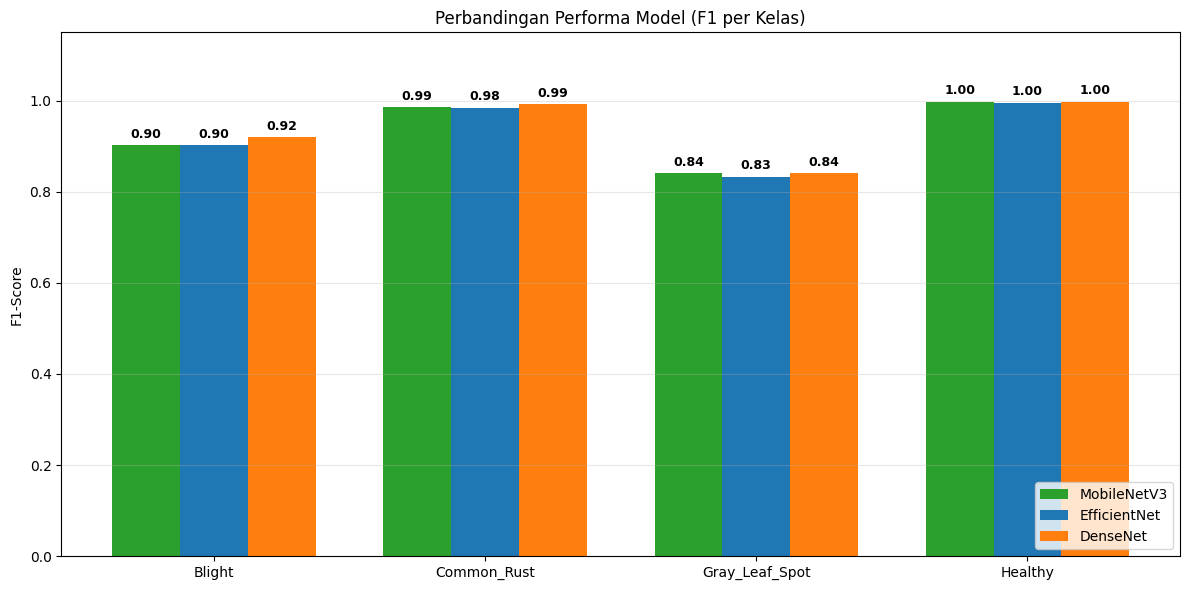

In [30]:
# ============================================================
# EVALUASI MULTI-MODEL + AUTO FIND FILE + PLOT F1 PER KELAS
# (MobileNetV3 - EfficientNet - DenseNet)  [TANPA drive_folder]
# ============================================================

import os                                      # untuk cek path file model/dataset & buat folder output
import numpy as np                             # untuk hitung steps, argmax prediksi, dan posisi bar chart
import matplotlib.pyplot as plt                # untuk plot grafik F1 per kelas

from tensorflow.keras.models import load_model # load model .keras untuk inference (tanpa training config)
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # baca image dari folder + preprocessing
from sklearn.metrics import classification_report                   # hitung precision/recall/F1 per kelas

# preprocess khusus tiap arsitektur (WAJIB sesuai training)
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenetv3_prep
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_prep
from tensorflow.keras.applications.densenet import preprocess_input as densenet_prep


# ============================================================
# 1) PATH DATASET & MODEL FOLDER
# ============================================================
base_dir = "jagung_dataset"        # folder dataset: harus langsung berisi subfolder kelas (Blight/Healthy/dll)
models_dir = "."                   # "." = file model berada di folder kerja saat ini; ubah jadi "models" jika disimpan di folder khusus

VAL_SPLIT = 0.2                    # 0.2 = 20% untuk validasi; alasan: umum dipakai (80/20) & konsisten dg training kamu
IMG_SIZE = (224, 224)              # 224x224: standar input pretrained ImageNet, adil untuk semua backbone, cukup detail tapi tidak berat
BATCH_SIZE = 32                    # 32: “sweet spot” kecepatan vs memori (umumnya aman di Colab); kalau OOM turunkan 16/8
SEED = 42                          # seed untuk membuat pembagian split & urutan dataset konsisten (reproducible untuk paper)

# output untuk penelitian (grafik + report)
SAVE_DIR = "eval_outputs"          # semua hasil evaluasi disimpan di folder ini agar rapi
SAVE_PNG = True                    # True: simpan grafik dalam PNG (umum untuk laporan)
SAVE_PDF = False                   # True jika mau versi PDF (bagus untuk paper)
DPI = 300                          # 300 dpi: standar kualitas gambar untuk publikasi/paper


# ============================================================
# 2) DAFTAR MODEL (nama -> filename)
# ============================================================
model_filenames = {
    "MobileNetV3": "model_jagung_mobilenetv3_vFinal.keras",   # format .keras lebih robust dibanding .h5 untuk Keras modern
    "EfficientNet": "model_jagung_efficientnet_vFinal.keras",
    "DenseNet": "model_jagung_densenet_vFinal.keras",
}

preprocess_map = {
    "MobileNetV3": mobilenetv3_prep,   # penting: normalisasi input MobileNetV3 berbeda
    "EfficientNet": efficientnet_prep, # penting: EfficientNet punya skema preprocess sendiri
    "DenseNet": densenet_prep,         # penting: DenseNet preprocess sendiri
}

colors = {
    "MobileNetV3": "#2ca02c",   # hijau: konsisten untuk semua grafik
    "EfficientNet": "#1f77b4",  # biru
    "DenseNet": "#ff7f0e",      # oranye
}


# ============================================================
# 3) FUNGSI: cari file model (lokal saja)
# ============================================================
def find_model_path(filename, models_dir="."):
    path = os.path.join(models_dir, filename)  # gabungkan folder model + nama file
    if os.path.exists(path):                   # cek file ada atau tidak (anti error "file not found")
        print(f"   ✅ Ditemukan: {path}")
        return path

    print(f"   ❌ File tidak ditemukan: {path}")
    return None                                # return None => model akan di-skip tanpa bikin program crash


# ============================================================
# 4) EVALUASI + SIMPAN F1 PER KELAS
# ============================================================
# results menyimpan list F1 per kelas untuk tiap model: {ModelName: [f1_kelas1, f1_kelas2, ...]}
results = {}

# untuk memastikan urutan kelas selalu konsisten, kita simpan "class_names_ref" sekali saja
class_names_ref = None

# buat folder output (kalau sudah ada tidak error)
os.makedirs(SAVE_DIR, exist_ok=True)

print("🔄 Memulai Evaluasi Multi-Model...")

for name, filename in model_filenames.items():
    print(f"\n🔍 Memproses: {name}")

    # (1) cari file model
    model_path = find_model_path(filename, models_dir=models_dir)
    if model_path is None:
        print(f"   ⏩ Skip {name} (file model tidak ada).")
        continue

    # (2) load model untuk inference
    try:
        model = load_model(model_path, compile=False)
        # compile=False: lebih cepat & tidak butuh optimizer/loss (kita hanya predict), juga mengurangi masalah kompatibilitas
    except Exception as e:
        print(f"   ❌ Gagal load model {name}: {e}")
        continue

    # (3) generator validasi (tanpa augment acak)
    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_map[name], # hanya preprocess (evaluasi harus “bersih”, tidak boleh augment acak)
        validation_split=VAL_SPLIT                   # gunakan split yang sama seperti training agar adil
    )

    val_gen = test_datagen.flow_from_directory(
        base_dir,                     # sumber data: folder dataset
        target_size=IMG_SIZE,         # resize konsisten dengan input model saat training
        batch_size=BATCH_SIZE,        # batch untuk efisiensi inference; tidak mengubah skor, hanya speed/memori
        class_mode="categorical",     # output label one-hot (standar multi-class), meski y_true diambil dari val_gen.classes
        subset="validation",          # ambil 20% bagian validasi
        shuffle=False,                # WAJIB: agar urutan y_true sinkron dengan output prediksi
        seed=SEED                     # agar pemilihan subset validasi konsisten (reproducible)
    )

    # (4) ambil nama kelas dari generator (paling aman)
    class_names = list(val_gen.class_indices.keys())
    # Kenapa ini penting?
    # - menghindari salah urutan label (hardcode rawan mismatch)
    # - kalau ada perubahan folder kelas, mapping tetap benar

    # simpan referensi urutan kelas sekali saja supaya plot semua model konsisten
    if class_names_ref is None:
        class_names_ref = class_names
    else:
        # kalau ada mismatch urutan kelas, itu bahaya (hasil bisa salah interpretasi)
        if class_names != class_names_ref:
            print("⚠️ WARNING: urutan class_indices berbeda antar generator! Pakai class_names_ref sebagai acuan plot.")
            # (umumnya tidak terjadi kalau base_dir sama dan seed sama)

    # (5) prediksi semua data validasi
    steps = int(np.ceil(val_gen.samples / val_gen.batch_size))
    # Kenapa pakai ceil?
    # - supaya semua sampel ter-cover walaupun batch terakhir tidak penuh
    # - tanpa ceil, bisa saja batch terakhir “kelewat” => jumlah prediksi kurang

    print(f"   -> Memprediksi {val_gen.samples} gambar (steps={steps}) ...")
    val_gen.reset()                                  # reset pointer generator ke batch awal
    y_prob = model.predict(val_gen, steps=steps, verbose=1)

    # kadang output prediksi bisa lebih panjang karena steps=ceil -> kita potong biar pas jumlah sampel
    y_prob = y_prob[:val_gen.samples]

    y_pred = np.argmax(y_prob, axis=1)               # ambil index prob terbesar => label prediksi final per gambar
    y_true = val_gen.classes                         # label asli integer dari generator (sinkron karena shuffle=False)

    # (6) classification report
    report_dict = classification_report(
        y_true,
        y_pred,
        target_names=class_names,                    # nama kelas sesuai mapping generator
        output_dict=True                             # output dict => gampang ambil f1-score per kelas
    )

    # simpan F1 sesuai urutan class_names_ref (supaya semua model align)
    # Kenapa align?
    # - agar bar chart membandingkan kelas yang sama pada posisi yang sama
    results[name] = [report_dict[c]["f1-score"] for c in class_names_ref]



# ============================================================
# 5) PLOT F1 PER KELAS + SAVE GRAFIK
# ============================================================
if not results:
    print("\n❌ Tidak ada hasil yang bisa diplot (cek file model & path).")
else:
    print("\n📊 Menampilkan Grafik F1 per Kelas...")

    x = np.arange(len(class_names_ref))             # posisi x untuk tiap kelas (0..jumlah_kelas-1)
    width = 0.25                                    # lebar batang; cocok untuk 3 model (total lebar grup ~0.75 masih ada jarak)

    fig, ax = plt.subplots(figsize=(12, 6))         # 12x6: cukup untuk 4 kelas + 3 model + label angka

    total_models = len(results)
    for i, (model_name, scores) in enumerate(results.items()):
        # rumus agar batang tetap “centered” walaupun jumlah model yang berhasil tidak selalu 3
        pos = x + (i - (total_models - 1) / 2) * width

        rects = ax.bar(
            pos,
            scores,
            width,
            label=model_name,
            color=colors.get(model_name, "gray")
        )

        # tulis nilai F1 di atas bar (2 desimal cukup: tidak terlalu ramai tapi beda masih terlihat)
        for r in rects:
            h = r.get_height()
            ax.annotate(
                f"{h:.2f}",
                xy=(r.get_x() + r.get_width() / 2, h),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold"
            )

    ax.set_ylabel("F1-Score")
    ax.set_title("Perbandingan Performa Model (F1 per Kelas)")
    ax.set_xticks(x)
    ax.set_xticklabels(class_names_ref)
    ax.set_ylim(0, 1.15)                            # 1.15 memberi ruang untuk teks nilai di atas bar agar tidak kepotong
    ax.legend(loc="lower right")
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()

    # =========================
    # SAVE GRAFIK (PNG/PDF)
    # =========================
    if SAVE_PNG:
        out_png = os.path.join(SAVE_DIR, "f1_per_kelas_comparison.png")
        plt.savefig(out_png, dpi=DPI, bbox_inches="tight")     # bbox_inches agar label tidak kepotong
        print(f"🖼️ Grafik tersimpan: {out_png}")

    if SAVE_PDF:
        out_pdf = os.path.join(SAVE_DIR, "f1_per_kelas_comparison.pdf")
        plt.savefig(out_pdf, bbox_inches="tight")
        print(f"📄 Grafik tersimpan: {out_pdf}")

    plt.show()


💾 Menghitung Ukuran File Model...
   📂 MobileNetV3: 32.93 MB
   📂 EfficientNet: 33.78 MB
   📂 DenseNet: 56.99 MB
🖼️ Grafik disimpan ke: eval_outputs/model_file_size_comparison.png


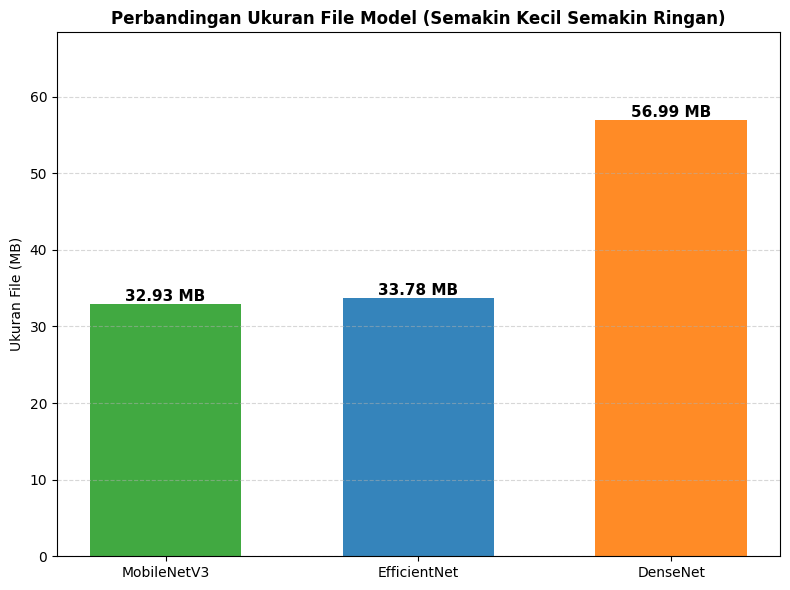

In [31]:
import os                                           # untuk cek file ada/tidak + ambil ukuran file (bytes)
import matplotlib.pyplot as plt                     # untuk membuat grafik batang (bar chart)

# ============================================================
# 1) DAFTAR FILE MODEL (MobileNetV3, EfficientNet, DenseNet)
# ============================================================
model_files = {                                     # dict: memetakan "nama model" -> "nama file"
    "MobileNetV3": "model_jagung_mobilenetv3_vFinal.keras",     # MobileNetV3: biasanya ringan, cocok untuk deployment
    "EfficientNet": "model_jagung_efficientnet_vFinal.keras",   # EfficientNet: trade-off bagus akurasi vs ukuran
    "DenseNet": "model_jagung_densenet_vFinal.keras"            # DenseNet: sering lebih besar karena arsitektur lebih kompleks
}
# Kenapa pakai dict?
# - rapi: nama model jadi key, file jadi value
# - gampang diloop + gampang ditambah (cukup tambah 1 baris)

# ============================================================
# 2) KONFIG OUTPUT (SAVE GRAFIK)
# ============================================================
SAVE_DIR = "eval_outputs"                           # folder output agar hasil rapi (satu tempat dengan hasil evaluasi lain)
SAVE_NAME = "model_file_size_comparison.png"        # nama file output grafik
DPI = 300                                           # 300 dpi = standar kualitas gambar untuk paper/laporan

os.makedirs(SAVE_DIR, exist_ok=True)                # buat folder jika belum ada; exist_ok=True agar tidak error kalau sudah ada
save_path = os.path.join(SAVE_DIR, SAVE_NAME)       # path lengkap file output

# ============================================================
# 3) HITUNG UKURAN FILE MODEL (DALAM MB)
# ============================================================
model_sizes = {}                                    # simpan hasil ukuran MB per model
print("💾 Menghitung Ukuran File Model...")

for name, file_path in model_files.items():         # loop setiap (nama_model, nama_file)
    if os.path.exists(file_path):                   # cek file benar-benar ada
        # getsize() mengembalikan ukuran dalam BYTES
        # Kenapa konversi ke MB (MiB)?
        # - lebih mudah dibaca (misal 18.40 MB) dibanding bytes (19283712 bytes)
        # Kenapa pakai 1024?
        # - standar biner: 1 KiB=1024 bytes, 1 MiB=1024 KiB
        size_mb = os.path.getsize(file_path) / (1024 * 1024)     # bytes -> MiB
        model_sizes[name] = size_mb                              # simpan ke dict
        print(f"   📂 {name}: {size_mb:.2f} MB")                 # 2 desimal: cukup presisi tapi tetap rapi
    else:
        # Kenapa tidak crash kalau file hilang?
        # - supaya script tetap jalan dan grafik tetap keluar
        # - nilai 0 jadi indikator visual file tidak ditemukan
        print(f"   ⚠️ {name}: File tidak ditemukan -> {file_path}")
        model_sizes[name] = 0.0

# ============================================================
# 4) SIAPKAN DATA UNTUK PLOT
# ============================================================
names = list(model_sizes.keys())                    # label sumbu X: nama model
sizes = list(model_sizes.values())                  # nilai sumbu Y: ukuran MB
# Kenapa dibuat list?
# - matplotlib butuh sequence/list untuk X dan Y

# ============================================================
# 5) BUAT GRAFIK BAR
# ============================================================
plt.figure(figsize=(8, 6))                          # 8x6 inch: pas untuk 3 bar + judul + label + angka
# Kenapa 8x6?
# - tidak terlalu lebar, tapi cukup ruang untuk teks & grid

colors = ["#2ca02c", "#1f77b4", "#ff7f0e"]           # hijau/biru/oranye: kontras jelas & konsisten dengan grafik lain
# Kenapa warna ini?
# - mudah dibedakan
# - konsisten antar visualisasi (memudahkan pembaca paper)

bars = plt.bar(
    names,                                           # X: nama model
    sizes,                                           # Y: ukuran MB
    color=colors[:len(names)],                       # aman kalau model ditambah/berkurang (tidak out-of-range)
    alpha=0.9,                                       # 0.9: tampilan sedikit soft tapi tetap jelas
    width=0.6                                        # 0.6: bar cukup tebal + masih ada jarak antar bar
)
# Kenapa alpha=0.9?
# - 1.0 kadang terlalu “keras”
# - 0.9 tetap tegas, tapi lebih enak dilihat
# Kenapa width=0.6?
# - untuk 3 bar, 0.6 memberi proporsi rapi (tidak terlalu dempet/kurus)

plt.title("Perbandingan Ukuran File Model (Semakin Kecil Semakin Ringan)", fontsize=12, fontweight="bold")
plt.ylabel("Ukuran File (MB)")
plt.grid(axis="y", linestyle="--", alpha=0.5)       # grid horizontal tipis agar mudah baca tinggi bar
# Kenapa grid axis='y' saja?
# - membantu membaca nilai ukuran (Y)
# - grid vertikal bikin plot lebih ramai

# ============================================================
# 6) TULIS NILAI DI ATAS SETIAP BAR
# ============================================================
for bar in bars:
    height = bar.get_height()                       # tinggi bar = ukuran MB

    plt.text(
        bar.get_x() + bar.get_width() / 2,          # posisi X di tengah bar agar teks center
        height,                                     # posisi Y di puncak bar
        f"{height:.2f} MB",                         # 2 desimal: beda tipis tetap terlihat tapi tidak terlalu panjang
        ha="center", va="bottom",
        fontsize=11, fontweight="bold"
    )

# ============================================================
# 7) ATUR BATAS Y AGAR TEKS TIDAK KEPOTONG
# ============================================================
top = max(sizes) if max(sizes) > 0 else 1           # fallback 1 agar tidak error jika semua size=0
plt.ylim(0, top * 1.2)                              # tambah 20% ruang atas untuk label teks
# Kenapa *1.2?
# - supaya angka di atas bar tidak keluar dari area plot
# - 20% biasanya cukup aman untuk label "xx.xx MB"

plt.tight_layout()                                  # rapikan layout agar judul/label tidak terpotong

# ============================================================
# 8) SAVE GRAFIK
# ============================================================
plt.savefig(save_path, dpi=DPI, bbox_inches="tight") # bbox_inches="tight": mencegah label/judul kepotong saat disimpan
print(f"🖼️ Grafik disimpan ke: {save_path}")

plt.show()                                          # tampilkan grafik di layar
